<a href="https://colab.research.google.com/github/tis-abe-akira/langchain-academy/blob/main/module-3/streaming-interruption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

モジュール2では、グラフの状態とメモリをカスタマイズするいくつかの方法について学びました。

外部メモリを持つチャットボットを構築し、長時間にわたる会話を持続できるようにしました。

## Goals

このモジュールでは、`human-in-the-loop`という概念を掘り下げます。これは、メモリを基盤とし、ユーザーがさまざまな方法でグラフと直接対話できるようにします。

`human-in-the-loop`のための準備として、まずストリーミングについて詳しく説明します。ストリーミングは、実行中にグラフの出力（ノードの状態やチャットモデルのトークンなど）を視覚化するさまざまな方法を提供します。

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraphは、[ストリーミングを第一級にサポート](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming) して構築されています。

モジュール2のチャットボットを設定し、実行中にグラフから出力をストリーミングするさまざまな方法を紹介します。

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


python 3.11未満では、トークンごとのストリーミングを有効にするために`RunnableConfig`で`call_model`を使用する必要があることに注意してください。これは、[python 3.11未満でのみ必要](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/)です。このノートブックをCoLabで実行している場合、python 3.xを使用するため、ここに含めています。


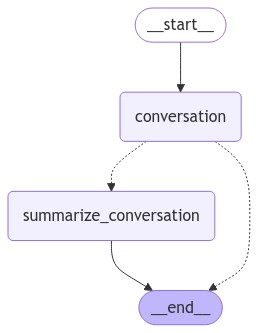

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

さて、グラフの状態をストリーミングする方法について説明しましょう。

`.stream`と`.astream`は、結果をストリーミングするための同期と非同期メソッドです。

LangGraphは、[グラフの状態](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)に対して、いくつかの[異なるストリーミングモード](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)をサポートしています。

* `values`: これは、各ノードが呼び出された後に、グラフの完全な状態をストリーミングします。
* `updates`: これは、各ノードが呼び出された後に、グラフの状態の更新をストリーミングします。

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

`stream_mode="updates"`を見てみましょう。

`updates`でストリーミングするため、グラフ内のノードが実行された後にのみ状態の更新が表示されます。

各`chunk`は、`node_name`をキーとし、更新された状態を値とする辞書です。


In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-51aa22d8-ff36-4876-8a69-001130b1c00f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


それでは、状態の更新だけを出力してみましょう。


In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! How's it going? If there's anything you'd like to talk about or need help with, feel free to let me know!


今度は、`stream_mode="values"`を見てみましょう。

これは、`conversation`ノードが呼び出された後のグラフの`完全な状態`です。

In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! How's it going? What can I do for you today?
---------------------------------------------------------------------------


### Streaming tokens

グラフの状態以外にもストリーミングしたい場合がよくあります。

特に、チャットモデルの呼び出しでは、トークンが生成される際にストリーミングするのが一般的です。

これは、[`.astream_events`メソッドを使用](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)して行うことができます。このメソッドは、ノード内で発生したイベントをストリーミングして返します！

各イベントは、いくつかのキーを持つ辞書です。

* `event`: これは、発生しているイベントの種類です。
* `name`: これは、イベントの名前です。
* `data`: これは、イベントに関連付けられたデータです。
* `metadata`: `langgraph_node`を含み、イベントを発行するノードです。

見てみましょう。

In [8]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

重要な点は、グラフ内のチャットモデルからのトークンには、`on_chat_model_stream`タイプがあることです。

`event['metadata']['langgraph_node']`を使用して、ストリーミングするノードを選択できます。

そして、`event['data']`を使用して、各イベントの実際のデータを取得できます。この場合、`AIMessageChunk`です。

In [9]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run-6aba67ca-8e19-4a51-ab58-3a5090664a3e')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_me

上記のように、`chunk`キーを使用して`AIMessageChunk`を取得するだけです。

In [10]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| club| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| founded| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|The| |49|ers| have| a| rich| history| and| are| one| of| the| most| successful| teams| in| NFL| history|.| They| have| won| five| Super| Bowl| championships|,| with| victories| in| Super| Bow|ls| XVI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|.| The| team| has| also| won| numerous| division| titles| and| made| many| playoff| appearances|.

|The| |49|ers| are| known| for| their| iconic| players| and| coaches|,| including| Hall| of| Fam|ers| like| Joe| Montana|,| Jerry| Rice|,| Steve| Young|,| Ronnie| L|ott|,| and| coach| Bill| W

### Streaming with LangGraph API

--

**⚠️ 免責事項**

* Studioの実行には現在Macが必要です。Macを使用していない場合は、この手順をスキップしてください。

* また、このノートブックをCoLabで実行している場合も、この手順をスキップしてください。

--

LangGraph APIは、[ストリーミングを第一級にサポート](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#streaming)しています。

`module-3/studio/agent.py`に設定された`module-3/studio/langgraph.json`を使用するStudio UIに`agent`を読み込みましょう。

LangGraph APIは、Studioのバックエンドとして機能します。

LangGraph SDKを介して、LangGraph APIと直接やり取りできます。

StudioからローカルデプロイメントのURLを取得するだけです。

![Screenshot 2024-08-27 at 2.20.34 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf8943c3d4df239cbf0f_streaming2.png)

In [11]:
import platform

if 'google.colab' in str(get_ipython()) or platform.system() != 'Darwin':
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

Exception: Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac

In [12]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:56091"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

ConnectError: All connection attempts failed

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [13]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

ConnectError: All connection attempts failed

The streamed objects have:

* `event`: Type
* `data`: State

In [ ]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='f51807de-6b99-4da4-a798-26cf59d16412'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-fa4ab1c6-274d-4be5-8c4a-a6411c7c35cc' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='3e7bbfb6-aa82-453a-969c-9c753fbd1d74' tool_call_id='call_imZHAw7kvMR2ZeKaQVSlj25C'
conte

APIを介してのみサポートされている新しいストリーミングモードがいくつかあります。

たとえば、[ `messages`モードを使用](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/)して、上記のケースをより適切に処理できます！

このモードは、現在、グラフに`messages`キーがあり、それがメッセージのリストであることを前提としています。

`messages`モードを使用して発行されたすべてのイベントには、次の2つの属性があります。

* `event`: これはイベントの名前です
* `data`: これはイベントに関連付けられたデータです

In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="messages"):
    print(event.event)

ConnectError: All connection attempts failed

いくつかのイベントを確認できます。

* `metadata`: 実行に関するメタデータ
* `messages/complete`: 完全なメッセージ
* `messages/partial`: チャットモデルのトークン

これらの種類の詳細については、[こちら](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)をご覧ください。

それでは、これらのメッセージをストリーミングする方法を示します。

メッセージのツール呼び出しの書式設定を改善するためのヘルパー関数を定義します。

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):

    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 1ef6a3da-687f-6253-915a-701de5327165
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal